In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import numpy as np
import unicodedata
import string
import glob
import time
import math
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

torch.set_printoptions(precision=4)
use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")

# Turn a Unicode string to plain ASCII  
def unicode_to_ascii(s, all_letters):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn'
                   and c in all_letters)

# Read a file and split into lines
def read_lines(filename, all_letters):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line, all_letters) for line in lines]

def get_categories(path, all_letters):
    category_lines = []
    all_categories = []
    for filename in glob.glob(path):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = read_lines(filename, all_letters)
        for line in lines:
            category_lines.append([line, category, len(line)])    
    np.random.shuffle(category_lines)
    return category_lines, all_categories

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter, all_letters):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line, n_letters, all_letters):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letter_to_index(letter, all_letters)] = 1
    return tensor

def category_from_output(output, all_categories):
    categories = []
    winners = []
    for row in range(output.shape[0]):
        top_n, top_i = output[row].topk(1)
        winner = top_i[0].item()
        categories.append(all_categories[winner])
        winners.append(winner)
    return winners, categories

# Model definition

In [2]:
class HomeworkNet(nn.Module):
    def __init__(self, vocab_size, n_layers, hidden_size, n_categories):
        super(HomeworkNet, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(vocab_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, n_categories)

    def forward(self, input, lengths, states):
        hidden, cell = states[0], states[1]
        input = pack_padded_sequence(input, lengths)
        out, (hidden, cell) = self.lstm(input.to(device), (hidden.to(device), cell.to(device)))
#         if n_layers > 1:
#             hidden = torch.cat([h for h in hidden], dim=1)
        out = self.fc(hidden[-1]) # feed topmost layer's hidden state into linear
        return out, (hidden, cell)

    def init_hidden(self, batch_size):
        # standard way - if you call .cuda() on the model it’ll return cuda tensors instead.
        hidden = Variable(next(self.parameters()).data.new(self.n_layers, batch_size, self.hidden_size))
        cell =  Variable(next(self.parameters()).data.new(self.n_layers, batch_size, self.hidden_size))
        return hidden.zero_(), cell.zero_()

# Data Loading

In [4]:
def get_batches(category_lines, n_categories, all_categories, n_letters, all_letters, batch_size):
    batch_count = 0
    batches = []
    batch = []
    for data in category_lines:
        batch_count += 1
        sample = {}
        sample['name'] = data[0]
        sample['category'] = data[1]
        sample['length'] = data[2]
        sample['name_tensor'] = line_to_tensor(data[0], n_letters, all_letters)
        sample['category_tensor'] = torch.tensor(all_categories.index(data[1]))
        batch.append(sample)
        if batch_count == batch_size:
            padded_batch = pad_batch(batch)
            batches.append(padded_batch)
            batch_count, batch = 0, []
    return batches
        
def pad_batch(batch):
    batch.sort(reverse = True, key = lambda x: x['length'])
    batch_names = [x['name_tensor'] for x in batch]
    batch_categories = [x['category_tensor'] for x in batch]
    batch_lengths = [x['length'] for x in batch]
    return([pad_sequence(batch_names).to(device),
            torch.stack(batch_categories).type(torch.LongTensor).to(device),
            torch.tensor(batch_lengths).to(device)])

# Training

In [24]:
def run(batch_size, learning_rate, n_hidden, n_layers, num_epochs=10):    
    
    # Optional: add an argument to the loss function
    # CrossEntropyLoss(weight=compute_loss_weights()).
    # This is observed to reduce validation and test
    # accuracy, but might be useful for unseen input.
    def compute_loss_weights():
        clsses = np.arange(0,18) # n_categories
        d = [{}, {}, {}]
        for i in range(18):
            d[0][all_categories[i]] = 0
            d[1][all_categories[i]] = 0
            d[2][all_categories[i]] = 0

        sets = [train_set, val_set, test_set]
        for idx in range(len(sets)):
            # for variable length sets (x is batch idx)
            for x in range(len(sets[idx])):
                # for every class index in that batch
                for cls in sets[idx][x][1]:
                    d[idx][all_categories[cls.item()]] += 1
        train_distribution = np.array(list((d[0].values())))
        minimum_frequency = np.min(train_distribution)
        
        # Here use either of the following. Remember to scale
        # the learning rate accordingly.
        # loss_weights = minimum_frequency / train_distribution
        # loss_weights = 1 / train_distribution
        loss_weights = 1 / train_distribution
        return torch.FloatTensor(loss_weights).to(device)

    def train(rnn, optimizer, epoch):
        rnn.train()
        correct = 0
        running_loss = 0

        for idx, data in enumerate(train_set):
            optimizer.zero_grad()
            packed_names, categories, lengths = data[0], data[1], data[2]
            batch_size = categories.shape[0]
            hidden, cell = rnn.init_hidden(batch_size)
            output, _ = rnn(packed_names.data, lengths, (hidden, cell))
            loss = criterion(output, categories)
            loss.backward()
            optimizer.step()
            running_loss += loss
            _, pred = torch.max(output, dim=1)
            correct += torch.sum(pred == categories)

        average_loss = running_loss / len(train_set)
        accuracy = correct.item() / (len(train_set) * batch_size) * 100.
        train_losses.append(average_loss.item())
        print("Training | Epoch {}\t| Average Loss: {}\t| Accuracy: {}/{} ({}%)".format(epoch, average_loss, correct,
                 len(train_set) * batch_size,
                 np.round(accuracy, 4)))

    def validate(rnn, epoch):
        rnn.eval()
        correct = 0
        running_loss = 0

        with torch.no_grad():
            for idx, data in enumerate(val_set):
                packed_names, categories, lengths = data[0], data[1], data[2]
                batch_size = categories.shape[0]
                hidden, cell = rnn.init_hidden(batch_size)
                output, _ = rnn(packed_names.data, lengths, (hidden, cell))
                loss = criterion(output, categories)
                running_loss += loss
                _, pred = torch.max(output, dim=1)
                correct += torch.sum(pred == categories)

        average_loss = running_loss / len(val_set)
        accuracy = correct.item() / (len(val_set) * batch_size) * 100.
        val_losses.append(average_loss.item())
        val_acc.append(accuracy)
        print("Validation | Epoch {}\t| Average Loss: {}\t| Accuracy: {}/{} ({}%)".format(epoch, average_loss, correct,
                 len(val_set) * batch_size,
                 np.round(accuracy, 4)))

    torch.cuda.manual_seed_all(17)    
    all_letters = string.ascii_letters + " .,;'"
    category_lines, all_categories = get_categories('data/names/*.txt', all_letters)
    n_letters = len(all_letters)
    n_categories = len(all_categories)

    # total samples: 20074.
    # we do a (0.7,0.1,0.2) split
    # that is (14051,2007,4016) split.
    train_set = get_batches(category_lines[:14051], n_categories, all_categories, n_letters, all_letters, batch_size)
    val_set = get_batches(category_lines[14051:16058], n_categories, all_categories, n_letters, all_letters, batch_size)
    test_set = get_batches(category_lines[16058:], n_categories, all_categories, n_letters, all_letters, batch_size)

    rnn = HomeworkNet(n_letters, n_layers, n_hidden, n_categories).to(device)
    
    # Possible modifications here:
    # add weight=compute_loss_weights(), or ignore_index=0
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

    # Keep track of losses for plotting
    current_loss = 0
    train_losses = []
    val_losses = []
    val_acc = []

    for epoch in range(1, num_epochs + 1):
        train(rnn, optimizer, epoch)
        validate(rnn, epoch)

    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)

    def test(rnn):
        rnn.eval()
        correct = 0
        running_loss = 0

        with torch.no_grad():
            for idx, data in enumerate(test_set):
                packed_names, categories, lengths = data[0], data[1], data[2]
                batch_size = categories.shape[0]
                hidden, cell = rnn.init_hidden(batch_size)
                output, _ = rnn(packed_names.data, lengths, (hidden, cell))
                loss = criterion(output, categories)
                running_loss += loss
                _, pred = torch.max(output, dim=1)
                correct += torch.sum(pred == categories)

                g, _ = category_from_output(output, all_categories)
                c = categories.tolist()

                for i in range(len(g)):
                    confusion[g[i], c[i]] += 1

        average_loss = running_loss / len(test_set)
        accuracy = correct.item() / (len(test_set) * batch_size) * 100.
        print("Test | Average Loss: {}\t| Accuracy: {}/{} ({}%)".format(average_loss, correct,
                 len(test_set) * batch_size,
                 np.round(accuracy, 4)))
        return average_loss, accuracy

    # (Optional) Plot a confusion matrix
    def plot_confusion_matrix(confusion):
        import matplotlib.pyplot as plt
        # Normalize by dividing every row by its sum
        for i in range(n_categories):
            confusion[i] = confusion[i] / confusion[i].sum()
        # Set up plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(confusion.numpy())
        fig.colorbar(cax)
        # Set up axes
        ax.set_xticklabels([''] + all_categories, rotation=90)
        ax.set_yticklabels([''] + all_categories)
        # Force label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        # sphinx_gallery_thumbnail_number = 2
        plt.show()
        
    test_loss, test_accuracy = test(rnn)
    params = (batch_size, learning_rate, n_hidden, n_layers, num_epochs)
    return train_losses, val_losses, val_acc, test_loss, test_accuracy, params


if __name__ == '__main__':
    b = [1,10,30]
    l = [0.01, 0.1, 1]
    h = [32, 64, 128]
    n = [1, 2]

    train_history = []
    test_history = []
    val_history = []
    
    # Iterate over different variables in b, l, h, n to run the desired experiments.
    for bs in b:
        print("Model Params: batchsize={}".format(bs))
        train_losses, val_losses, val_acc, test_loss, test_acc, params = run(batch_size=bs, learning_rate=0.01, n_hidden=200, n_layers=1, num_epochs=20)
        train_history.append(train_losses)
        val_history.append([val_losses, val_acc])
        test_history.append([test_loss.item(), test_acc, params])    

Model Params: batchsize=1
Training | Epoch 1	| Average Loss: 1.0209521055221558	| Accuracy: 9738/14051 (69.3047%)
Validation | Epoch 1	| Average Loss: 0.8454248309135437	| Accuracy: 1475/2007 (73.4928%)
Training | Epoch 2	| Average Loss: 0.7425699830055237	| Accuracy: 10925/14051 (77.7525%)
Validation | Epoch 2	| Average Loss: 0.8003220558166504	| Accuracy: 1545/2007 (76.9806%)
Training | Epoch 3	| Average Loss: 0.6815886497497559	| Accuracy: 11175/14051 (79.5317%)
Validation | Epoch 3	| Average Loss: 0.7641557455062866	| Accuracy: 1570/2007 (78.2262%)
Training | Epoch 4	| Average Loss: 0.6488040089607239	| Accuracy: 11343/14051 (80.7274%)
Validation | Epoch 4	| Average Loss: 0.8007952570915222	| Accuracy: 1572/2007 (78.3259%)
Training | Epoch 5	| Average Loss: 0.6152140498161316	| Accuracy: 11478/14051 (81.6881%)
Validation | Epoch 5	| Average Loss: 0.7653822898864746	| Accuracy: 1559/2007 (77.6781%)
Training | Epoch 6	| Average Loss: 0.7173004150390625	| Accuracy: 11363/14051 (80.869

Training | Epoch 6	| Average Loss: 0.32501596212387085	| Accuracy: 12526/14040 (89.2165%)
Validation | Epoch 6	| Average Loss: 0.6170055866241455	| Accuracy: 1619/1980 (81.7677%)
Training | Epoch 7	| Average Loss: 0.28109240531921387	| Accuracy: 12734/14040 (90.698%)
Validation | Epoch 7	| Average Loss: 0.6905880570411682	| Accuracy: 1618/1980 (81.7172%)
Training | Epoch 8	| Average Loss: 0.24855361878871918	| Accuracy: 12884/14040 (91.7664%)
Validation | Epoch 8	| Average Loss: 0.6921539306640625	| Accuracy: 1619/1980 (81.7677%)
Training | Epoch 9	| Average Loss: 0.22378236055374146	| Accuracy: 12995/14040 (92.557%)
Validation | Epoch 9	| Average Loss: 0.6840863227844238	| Accuracy: 1626/1980 (82.1212%)
Training | Epoch 10	| Average Loss: 0.1992441564798355	| Accuracy: 13102/14040 (93.3191%)
Validation | Epoch 10	| Average Loss: 0.7128908634185791	| Accuracy: 1621/1980 (81.8687%)
Training | Epoch 11	| Average Loss: 0.20237530767917633	| Accuracy: 13085/14040 (93.198%)
Validation | Epo

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




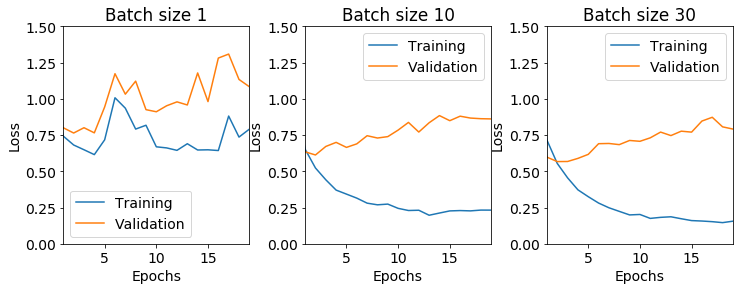

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(131)
plt.title("Batch size 1")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.xlim((1,19))
plt.ylim((0, 1.5))
plt.plot(train_history[0], label="Training")
plt.plot(val_history[0][0], label="Validation")
plt.legend()

plt.subplot(132)
plt.title("Batch size 10")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.xlim((1,19))
plt.ylim((0, 1.5))
plt.plot(train_history[1], label="Training")
plt.plot(val_history[1][0], label="Validation")
plt.legend()

plt.subplot(133)
plt.title("Batch size 30")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.xlim((1,19))
plt.ylim((0, 1.5))
plt.plot(train_history[2], label="Training")
plt.plot(val_history[2][0], label="Validation")
plt.legend()

#plt.subplot(133)
#plt.plot(val_history[0][1])
#plt.plot(val_history[1][1])
#plt.plot(val_history[2][1])

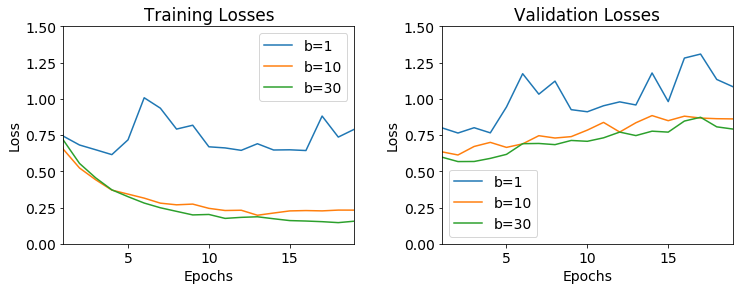

In [104]:
plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(121)
plt.title("Training Losses")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.xlim((1,19))
plt.ylim((0, 1.5))
plt.plot(train_history[0], label="b=1")
plt.plot(train_history[1], label="b=10")
plt.plot(train_history[2], label="b=30")
plt.legend()

plt.subplot(122)
plt.title("Validation Losses")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.xlim((1,19))
plt.ylim((0, 1.5))
plt.plot(val_history[0][0], label="b=1")
plt.plot(val_history[1][0], label="b=10")
plt.plot(val_history[2][0], label="b=30")
plt.legend()

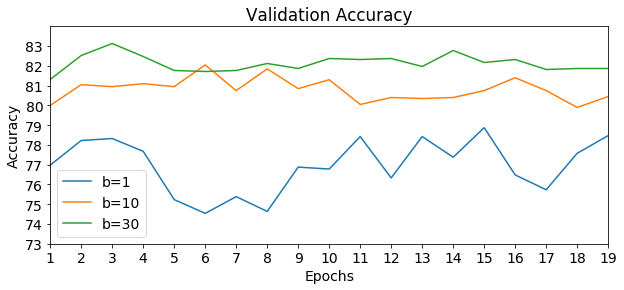

In [122]:
plt.figure(figsize=(10,4))
#plt.subplots_adjust(wspace=0.3)
plt.title("Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.xlim((1,19))
plt.ylim((73.0, 84.0))
plt.xticks(np.arange(1,20))
plt.yticks(np.arange(73,84))
plt.plot(val_history[0][1], label="b=1")
plt.plot(val_history[1][1], label="b=10")
plt.plot(val_history[2][1], label="b=30")
plt.legend()